# Demo: Predict pitch classes

This notebook shows how to load pretrained models for all main experiments of the paper and to predict pitch classes for unseen audio recordings.

&copy; Johannes Zeitler (johannes.zeitler@fau.de) and Christof Weiß (christof.weiss@audiolabs-erlangen.de), 2020/21

In [1]:
import os
import sys
import numpy as np
import librosa
import matplotlib.pyplot as plt
from harmonicCQT import HCQT, getHopSize
import tensorflow as tf
from FrameGenerators import PredictGenerator
from LibFMP.C3 import smooth_downsample_feature_sequence, normalize_feature_sequence

### 1. Specify paramters, select and load model

In [2]:
fs = 22050 # audio sample rate
rate = 10 # pitch class feature rate in Hz
f = 'Schubert_D911-23_SC06'

path_audio = os.path.join('Data', 'Schubert_Winterreise', 'audio_wav', f+'.wav')

# load audio
print('load and resample audio...')
audioIn, _ = librosa.load(path_audio, sr=fs, mono=True)

# Shorten audio to first 60 seconds
audioIn[:60*fs]

if rate not in (10, 50):
    assert false, 'Error: output rate must be 10Hz or 50Hz'

# HCQT config
cqt_frameRate = 50 # desired cqt rate (actual cqt rate is approx. 57Hz due to power-of-two-constraints...)
bottomNote = 'C1'
bottomPitch = librosa.note_to_midi(bottomNote)
numOctaves = 6
numHarmonics = 5
binsPerKey = 3
hopSizeCQT = getHopSize(fs, cqt_frameRate, numOctaves, numHarmonics) # actual cqt hop size (corresponds to 57Hz)

# compute HCQT
print('compute hcqt...')
hcqt, _, _ = HCQT(x=audioIn, fs=fs, frameRate=cqt_frameRate, f_min=bottomNote, binsPerKey=binsPerKey,
                  numOctaves=numOctaves, numHarmonics=numHarmonics, centerNoteToBins=True,
                  correctTuning=True)

# tensorflow generator for feeding HCQT batches to the network. Decrease batch_size if insufficient memory.
predictGen = PredictGenerator(hcqt, batch_size=100, numContextFrames=75, compression=10)


#### Select model, load and compile the network ############################

## Models from the cross-dataset experiments (Figure 3 of the paper): ##
# modelName = 'mCNN_trainMusicNet' # Trained on MusicNet
# modelName = 'mCNN_trainBeethovenPiano' ' # Trained on Beethoven Piano Sonatas
# modelName = 'mCNN_trainWagnerPianoScore' # Trained on Wagner Ring
# modelName = 'mCNN_trainMusicNet-BeethovenPiano-WagnerPianoScore' # Trained on Mix

## Models from different architectures trained on a mixed dataset (Figure 4 of the paper): ##
# modelName = 'mCNN_trainMusicNet-BeethovenPiano-WagnerPianoScore'  # Basic
# modelName = 'mCNN_trainMusicNet-BeethovenPiano-WagnerPianoScore_LastLayer10' # BasicLast10
# modelName = 'mCNN_WIDE_trainMusicNet-BeethovenPiano-WagnerPianoScore' # Wide
# modelName = 'mCNN_WIDE-Inception_trainMusicNet-BeethovenPiano-WagnerPianoScore' # WideInception
# modelName = 'mCNN_DEEP_trainMusicNet-BeethovenPiano-WagnerPianoScore' # Deep
# modelName = 'mCNN_DEEP-ResNet_trainMusicNet-BeethovenPiano-WagnerPianoScore' # DeepResNet

## Pitch-class features for chord recognition (Section 5 of the paper) ##
modelName = 'mCNN_WIDE_trainMusicNet-BeethovenPiano-WagnerPianoScore'    # for chord reco on Schubert Winterreise
# modelName = 'mCNN_WIDE_trainMusicNet-SMD-WagnerPianoScore'    # for chord reco on Beethoven Sonatas

############################################################################

print('load model ' + modelName)
model = tf.keras.models.load_model(os.path.join('Models', modelName), compile=False)
model.compile(loss = 'binary_crossentropy')

load and resample audio...
compute hcqt...
load model mCNN_WIDE_trainMusicNet-BeethovenPiano-WagnerPianoScore


### 2. Predict pitch classes

In [3]:
print('predict pitch classes...')
output = model.predict(predictGen).transpose()

# interpolate chromas to be sampled at _exactly_ 50Hz (instead of 57Hz, see above)
cqtTimes = np.arange(output.shape[1]) / (fs/hopSizeCQT)
targetTimes = np.arange(0, np.max(cqtTimes), 1/cqt_frameRate)
outputInterp = np.zeros((12, len(targetTimes)))
for i in range(12):
    outputInterp[i,:] = np.interp(targetTimes, cqtTimes, output[i,:])

# if required, downsample to 10Hz
if rate is 10:
    outputInterp,_ = smooth_downsample_feature_sequence(outputInterp, fs, filt_len=5, down_sampling=5, w_type='boxcar')

predict pitch classes...


### 3. Plot predictions together with annotations (ground truth)

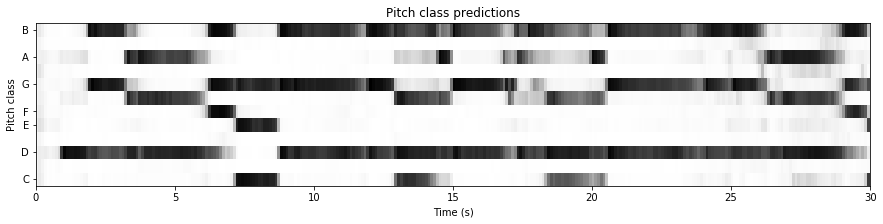

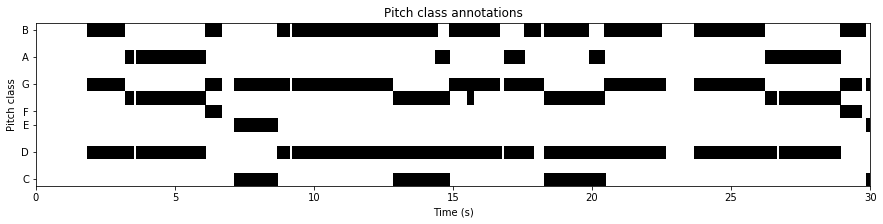

In [4]:
# Plot predictions
plt.figure(figsize=(14.95, 3))
librosa.display.specshow(outputInterp, y_axis='chroma', x_axis='s', sr=fs, hop_length=fs/rate, cmap='gray_r')
plt.xlim([0, 30])
plt.title('Pitch class predictions')
plt.show()

# Load and plot annotations
chromaPath_dest = os.path.join('Data', 'Schubert_Winterreise', 'Chroma')
chroma = np.load(os.path.join(chromaPath_dest, f+'.npy'))

plt.figure(figsize=(14.95, 3))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='s', sr=fs, hop_length=hopSizeCQT, cmap='gray_r')
plt.xlim([0, 30])
plt.title('Pitch class annotations')
plt.show()